# Probablistic Model

In [1]:
!pip install ray[tune]
import math
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn import preprocessing
from Training import model, utils, dataset, train
from sklearn.model_selection import train_test_split


import keras.backend as K

In [2]:
def check_acc(y_hat,y,margin=0.05):
    a_err = (np.abs(y_hat - y)) # get normalized error 
    err = np.divide(a_err, y, out=a_err, where=y==0)
    assert(err.shape == y.shape)
    num_correct = 0
    for row in err:
        num_in_row = len(np.where(row < margin)[0]) # margin * 100 because 
        if num_in_row == len(row):
            num_correct += 1

    num_samples = y.shape[0]
    correct_idx = np.where(err < margin)
    num_part_correct = len(correct_idx[0])
    num_part_samples = y.shape[0] * y.shape[1]
    print(f"Correct = {num_correct} / {num_samples}")
    return (num_correct/num_samples)
from matplotlib.patches import Ellipse
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip
def multivariate_gaussian_nll(ypreds, ytrue, var):
    
    diag = torch.exp(var[:,:2]) # convert log-scale var to
    n = ypreds.shape[1] #number of parameters ie number of means (2 gain and bandwidth)
    B = ypreds.shape[0] #Batch size
    
    z = torch.zeros(B)
    o = torch.ones(B)
    D = torch.stack((diag[:,0],z,z,diag[:,1]),dim=1).reshape(B,2,2) # form Diagnol matrix D for LDLT
    L = torch.stack((o,z,var[:,2],o),dim=1).reshape(B,2,2) # form L matrix 
    LT = torch.stack((o,var[:,2],z,o),dim=1).reshape(B,2,2) # form LT matrix (transpose of L)

    sigma = L @ D @ LT   # form sigma inv from LDLT decomp
    ximu =(ytrue-ypreds).reshape(B,2,1)  #true- minus 
    ximuT =(ytrue-ypreds).reshape(B,1,2) # true- minus  transpose

    loss = 0.5*torch.mean(ximuT@sigma@ximu + ((n/2)*(-torch.sum(var[:,:2],axis=1).reshape(B,1))))
    return loss
def formCovMatrix(var):
    diag = np.exp(var[:2])
    z = np.zeros(2)
    o = np.ones(2)
    D = np.array([diag[0],0,0,diag[1]]).reshape(2,2)
    L = np.array([1,0,var[2],1]).reshape(2,2)
    LT = np.array([1,var[2],0,1]).reshape(2,2)
    sigma = L @ D @ LT
    return np.linalg.pinv(sigma)

#### Load Data

In [3]:
data = utils.parseGainAndBWCsv2("Data/BW-3000.csv").astype(float)

#data = custom_data

In [4]:
print(data[0])

[6.200e+02 2.880e-06 3.775e+00 8.280e+10]


##### Split data into inputs X and target Y Normalize to [0,1] (inclusive) and create Training and Testign Splits


In [5]:
data = preprocessing.MinMaxScaler((0,1)).fit_transform(data)
X = data[:,:2]
Y = data[:,2:]

#### Define Model and Parameters

##### Define model

* Model: MLP with variable hidden layer number and width  
* Output layer: 
    * Node 1 and 2 are the mean for probability mean 
    * Node 3 and 4 are the diagonal of the covariance matrix


In [17]:
# num_hidden_layers = 5
# hidden_layer_size = 500

# model = tf.keras.models.Sequential([])

# for i in range(num_hidden_layers):
#     model.add(tf.keras.layers.Dense(hidden_layer_size, activation='relu'))
# model.add(tf.keras.layers.Dense(4, activation='sigmoid')) # add output layer: node 1,2 are 

In [18]:
test_model = model.DistModel50x10(2,5)

##### Define Loss

* Loss: guassian_nll
    * cite: https://gist.github.com/sergeyprokudin/4a50bf9b75e0559c1fcd2cae860b879e

In [19]:
optimizer = optim.Adagrad(test_model.parameters(),lr=0.001)
loss_fn = multivariate_gaussian_nll

dataset1 = dataset.CircuitSynthesisGainAndBandwidthManually(Y, X)
train_dataset, val_dataset = utils.splitDataset(dataset1, 0.95)
    
train_data = DataLoader(train_dataset,batch_size = 500)
validation_data = DataLoader(val_dataset, batch_size = 500)

In [ ]:
epochs = 250
loss_list, val_loss_list = train.trainProbModel(test_model, train_data, loss_fn, optimizer, num_epochs=epochs, print_every=10, validation_data=validation_data)

t = 10, loss = -1.4939, val loss = -1.4900
t = 20, loss = -1.5418, val loss = -1.5389
t = 30, loss = -1.6563, val loss = -1.6877
t = 40, loss = -1.8097, val loss = -1.8267
t = 50, loss = -1.9461, val loss = -1.9668
t = 60, loss = -2.0773, val loss = -2.1115
t = 70, loss = -2.2024, val loss = -2.2556
t = 80, loss = -2.3114, val loss = -2.3850
t = 90, loss = -2.4028, val loss = -2.4885
t = 100, loss = -2.4663, val loss = -2.5234
t = 110, loss = -2.5234, val loss = -2.5726
t = 120, loss = -2.5726, val loss = -2.6190
t = 130, loss = -2.6145, val loss = -2.6575
t = 140, loss = -2.6524, val loss = -2.6963
t = 150, loss = -2.6857, val loss = -2.7294
t = 160, loss = -2.7158, val loss = -2.7589
t = 170, loss = -2.7437, val loss = -2.7865
t = 180, loss = -2.7713, val loss = -2.7562
t = 190, loss = -2.7965, val loss = -2.8346
t = 200, loss = -2.8184, val loss = -2.8624


## Loss visualization

Loss plots for training and validation by epoch

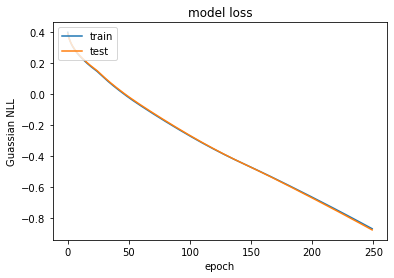

In [10]:
plt.plot(np.arange(len(loss_list)),loss_list)
plt.plot(np.arange(len(val_loss_list)),val_loss_list)
plt.title('model loss')
plt.ylabel('Guassian NLL')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing scipt

My idea of the testing script. 
It takes the inverse simulator prediction (Y -> X^)  
Pass X^ to mock_simulator to get Y^   
evaluate performance from Y to Y^  
I don't know if the data is being shuffled at all could contribute too the poor performance

In [11]:
x_preds = test_model(torch.Tensor(Y))
#print(x_preds)
mock_simulator = tf.keras.models.load_model('mock_simulator')
#mock_simulator = mockSimulator

final_preds = []
for i in range(x_preds.shape[0]):
    means = x_preds.detach().numpy()[i,:2].T
    w,r = means
    y_hat = mock_simulator(means.reshape(1,2)) # feed back through simulator to get evaluated performance
    final_preds.append(y_hat)
final_preds = np.array(final_preds).reshape(-1,2)
    

# for i,d in enumerate(final_preds):
#     print(Y[i],d)
print(final_preds)


2022-05-10 05:26:26.228763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-10 05:26:26.228819: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-10 05:26:26.228848: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-reevest): /proc/driver/nvidia/version does not exist
2022-05-10 05:26:26.229184: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[0.960203   0.01664999]
 [0.9728536  0.01216598]
 [0.97861254 0.01183782]
 ...
 [0.99954313 0.01077406]
 [0.98942965 0.01126148]
 [0.9756706  0.01194283]]


In [12]:
check_acc(Y,final_preds,margin=.05)

Correct = 897 / 3022


0.29682329583057576

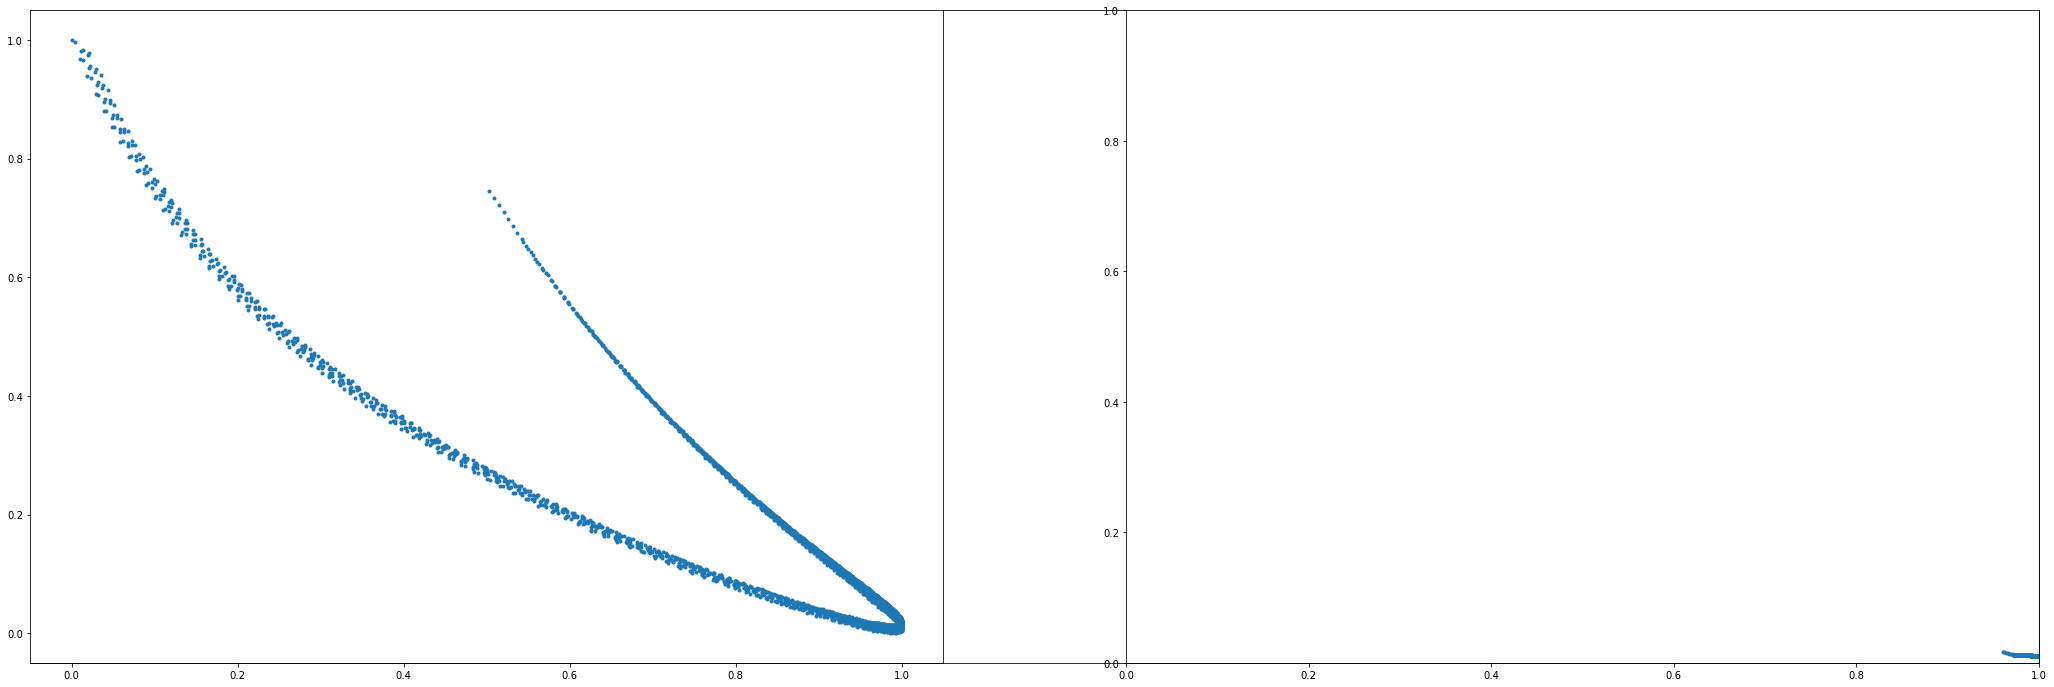

In [13]:
fig, axes = plt.subplots(figsize=(36, 12))
axes.get_xaxis().set_visible(False) # remove erroreas graph axis
axes.get_yaxis().set_visible(False)


xlim = [Y[:,0].min(),Y[:,0].max()]
ylim = [Y[:,1].min(),Y[:,1].max()]


ax = fig.add_subplot(121)
plt.plot(Y[:,0],Y[:,1], ".")
ax = fig.add_subplot(122)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.plot(final_preds[:,0],final_preds[:,1], ".")

plt.show()

In [14]:
def getCovEllip(cov,pos):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    theta = np.linspace(0, 2*np.pi, 1000);
    ellipsis = (np.sqrt(eigenvalues[None,:]) * eigenvectors) @ [np.sin(theta), np.cos(theta)] + pos.reshape(2,1)
    return ellipsis

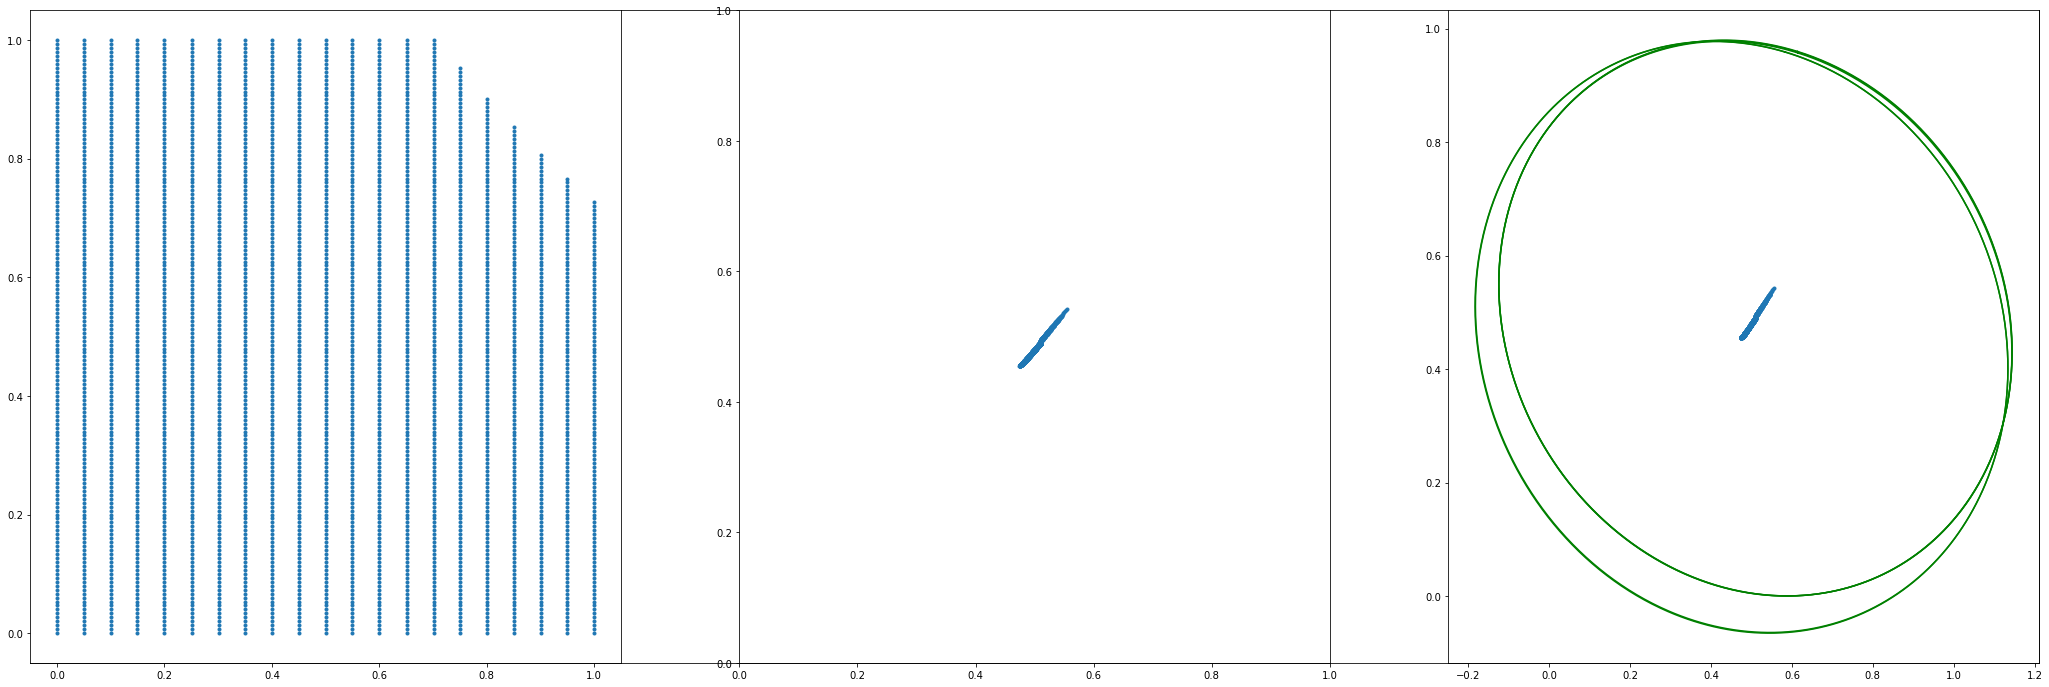

In [15]:
pred_means = x_preds.detach().numpy()[:,:2] # get meansd 

values = x_preds.detach().numpy()
fig, axes = plt.subplots(figsize=(36, 12))
axes.get_xaxis().set_visible(False) # remove erroneos graph axis
axes.get_yaxis().set_visible(False)

xlim = [X[:,0].min(),X[:,0].max()] # calculate limits for input data to set plot axis
ylim = [X[:,1].min(),X[:,1].max()]

num_ellipse = 5
ellipses = []
for i in range(num_ellipse):
    i = np.random.randint(values.shape[0])
    cov = values[i,2:]
    pos = values[i,:2]
    cov = formCovMatrix(cov)
    ellipses.append(getCovEllip(cov,pos))

ax = fig.add_subplot(131)
plt.plot(X[:,1],X[:,0], ".")
ax = fig.add_subplot(132)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.plot(pred_means[:,0],pred_means[:,1], ".")
ax = fig.add_subplot(133)
plt.plot(pred_means[:,0],pred_means[:,1], ".")
for ellipse in ellipses:
    plt.plot(ellipse[0,:], ellipse[1,:],"g")
plt.show()